# Neural Networks: Backpropagation with Pure Python

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FlorianMarquardt/machine-learning-for-physicists/blob/master/2024/02_MachineLearning_Backpropagation.ipynb)

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 2

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to:
- implement backpropagation in pure python

This is basically the code shown in the lecture, with a tiny bit of clean-up and extra comments.

This present version (mostly) follows the rules of functional programming: no side effects in any function!

### Imports: only numpy and matplotlib

In [78]:
# get the "numpy" library for linear algebra

import numpy as np

#from numpy import array, zeros, exp, random, dot, shape, reshape, meshgrid, linspace, transpose

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# Backpropagation

## Implement backpropagation for a general (fully connected) network

In [79]:
# def net_f_df(z): # calculate f(z) and f'(z)
#     val=1/(1+np.exp(-z)) # sigmoid
#     return val,np.exp(-z)*(val**2) # return both f and f'

In [191]:
# relu activation
def net_f_df(z): # calculate f(z) and f'(z)
    return (z>0)*z,z>0 # return both f and f'

In [192]:
def forward_step(y,w,b): # calculate values in next layer, from input y
    z=np.dot(y,w)+b # w=weights, b=bias vector for next layer
    return net_f_df(z) # apply nonlinearity and return result

In [193]:
def apply_net(x,Weights,Biases): # one forward pass through the network    
    y_layer=[] # to save the neuron values
    df_layer=[] # to save the f'(z) values
    y=x # start with input values
    y_layer.append(y)
    for w,b in zip(Weights,Biases): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,w,b) # one step
        df_layer.append(df) # store f'(z) [needed later in backprop]
        y_layer.append(y) # store f(z) [also needed in backprop]        
    return y,y_layer,df_layer

In [194]:
def apply_net_simple(x,Weights,Biases): # one forward pass through the network
    # no storage for backprop (this is used for simple tests)

    y=x # start with input values
    for w,b in zip(Weights,Biases): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,w,b) # one step
    return y

In [195]:
def backward_step(delta,w,df): 
    # delta (batchsize,layersize(N)), w (layersize(N-1),layersize(N))
    # df = df/dz at layer N-1, shape (batchsize,layersize(N-1))
    return  np.dot(delta,np.transpose(w))*df

In [196]:
def backprop(y_target,y_layer,df_layer,Weights,Biases): 
    # one backward pass through the network

    batchsize=np.shape(y_target)[0]
    num_layers=len(Weights) # number of layers excluding input
    dw_layer=[None]*num_layers # dCost/dw
    db_layer=[None]*num_layers # dCost/db
    
    delta=(y_layer[-1]-y_target)*df_layer[-1]
    dw_layer[-1]=np.dot(np.transpose(y_layer[-2]),delta)/batchsize
    db_layer[-1]=delta.sum(0)/batchsize
    
    for j in range(num_layers-1):
        delta=backward_step(delta,Weights[-1-j],df_layer[-2-j])
        dw_layer[-2-j]=np.dot(np.transpose(y_layer[-3-j]),delta)
        db_layer[-2-j]=delta.sum(0)/batchsize
        
    return dw_layer,db_layer # gradients for weights & biases

In [197]:
def gradient_step(eta,dw_layer, db_layer, Weights, Biases): 
    # update weights & biases (after backprop!)
    num_layers=len(Weights)
    for j in range(num_layers):
        Weights[j]-=eta*dw_layer[j]
        Biases[j]-=eta*db_layer[j]
    return Weights, Biases

In [198]:
def train_batch(x,y_target,eta,Weights,Biases): # one full training batch
    # x is an array of size batchsize x (input-layer-size)
    # y_target is an array of size batchsize x (output-layer-size)
    # eta is the stepsize for the gradient descent
    
    y_out_result,y_layer,df_layer=apply_net(x,Weights,Biases)
    dw_layer,db_layer=backprop(y_target,y_layer,df_layer,Weights,Biases)
    Weights,Biases=gradient_step(eta,dw_layer, db_layer, Weights, Biases)
    cost=((y_target-y_out_result)**2).sum()/batchsize
    return y_out_result,cost,Weights,Biases

## Setup for a particular set of layer sizes

In [199]:
# set up all the weights and biases

NumLayers=3 # does not count input-layer (but does count output)
LayerSizes=[2,20,30,1] # input-layer,hidden-1,hidden-2,...,output-layer

# initialize random weights and biases for all layers (except input of course)
Weights=[np.random.uniform(low=-1,high=+1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NumLayers)]
Biases=[np.random.uniform(low=-1,high=+1,size=LayerSizes[j+1]) for j in range(NumLayers)]

# define the batchsize
batchsize=32

## Train the net on one single batch repeatedly (not so good)

In [200]:
x=np.random.uniform(low=-1,high=+1,size=[batchsize,LayerSizes[0]])
y_target=np.random.uniform(low=-1,high=+1,size=[batchsize,LayerSizes[-1]])
eta=0.01

In [201]:
# one training step:
y_out_result,cost,Weights,Biases=train_batch(x,y_target,eta,Weights,Biases)

In [202]:
eta=0.01
batches=200

costs=[]

for k in range(batches):
    y_out_result,cost,Weights,Biases=train_batch(x,y_target,eta,Weights,Biases)
    costs.append(cost)

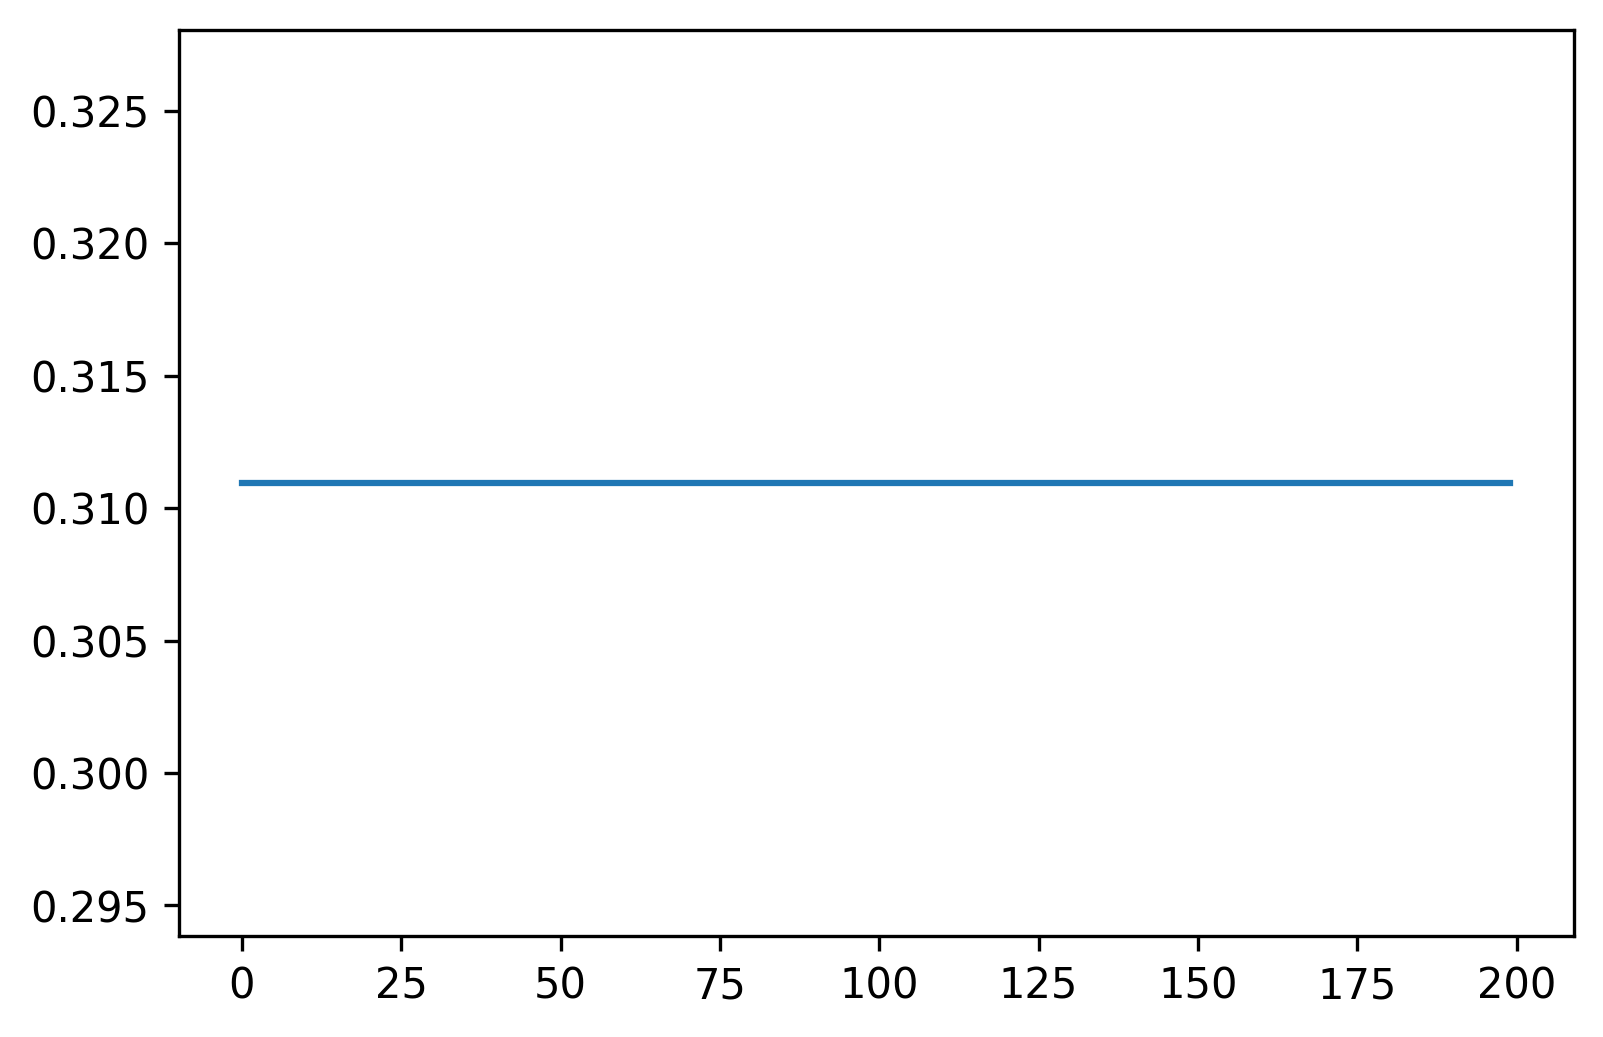

In [203]:
# this will show a very simple decrease, because
# we are not yet stochastically sampling inputs
# (it is always the SAME input! so the network
# only becomes good for that input)
plt.plot(costs)
plt.show()

### Produce random batches: randomly sample a function defined on a 2D square

In [204]:
# set up all the weights and biases

NumLayers=2 # does not count input-layer (but does count output)
LayerSizes=[2,100,1] # input-layer,hidden-1,hidden-2,...,output-layer

Weights=[np.random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NumLayers)]
Biases=[np.zeros(LayerSizes[j+1]) for j in range(NumLayers)]


In [205]:
# define the batchsize
batchsize=100

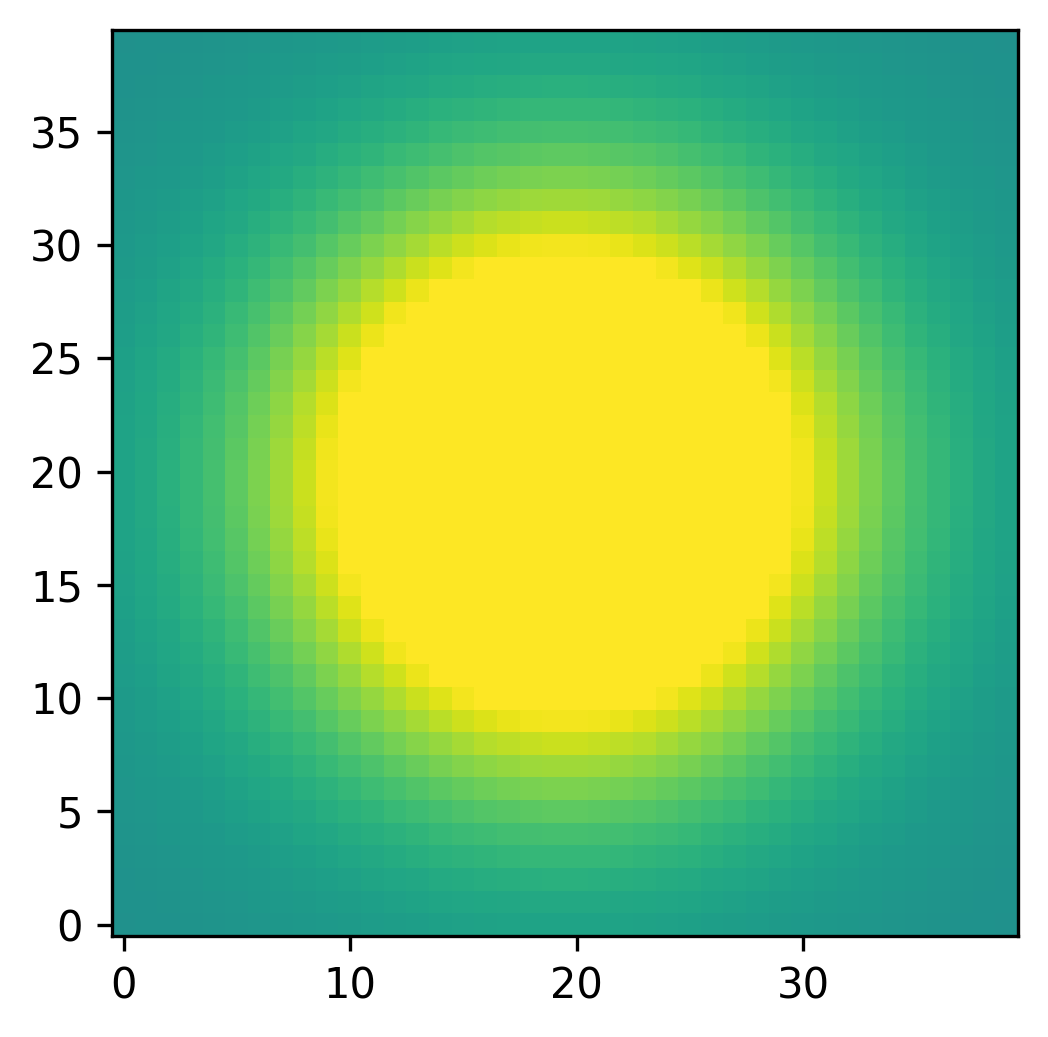

In [206]:
def myFunc(x0,x1):
    r2=x0**2+x1**2
    return(np.exp(-10*r2))

xrange=np.linspace(-0.5,0.5,40)
X0,X1=np.meshgrid(xrange,xrange)
plt.imshow(myFunc(X0,X1),interpolation='nearest',origin='lower',vmin=-.5,vmax=+.5)
plt.show()

In [207]:
def make_batch(batchsize):
    inputs=np.random.uniform(low=-0.5,high=+0.5,size=[batchsize,2])
    targets=np.zeros([batchsize,1]) # must have right dimensions
    targets[:,0]=myFunc(inputs[:,0],inputs[:,1])
    return inputs,targets

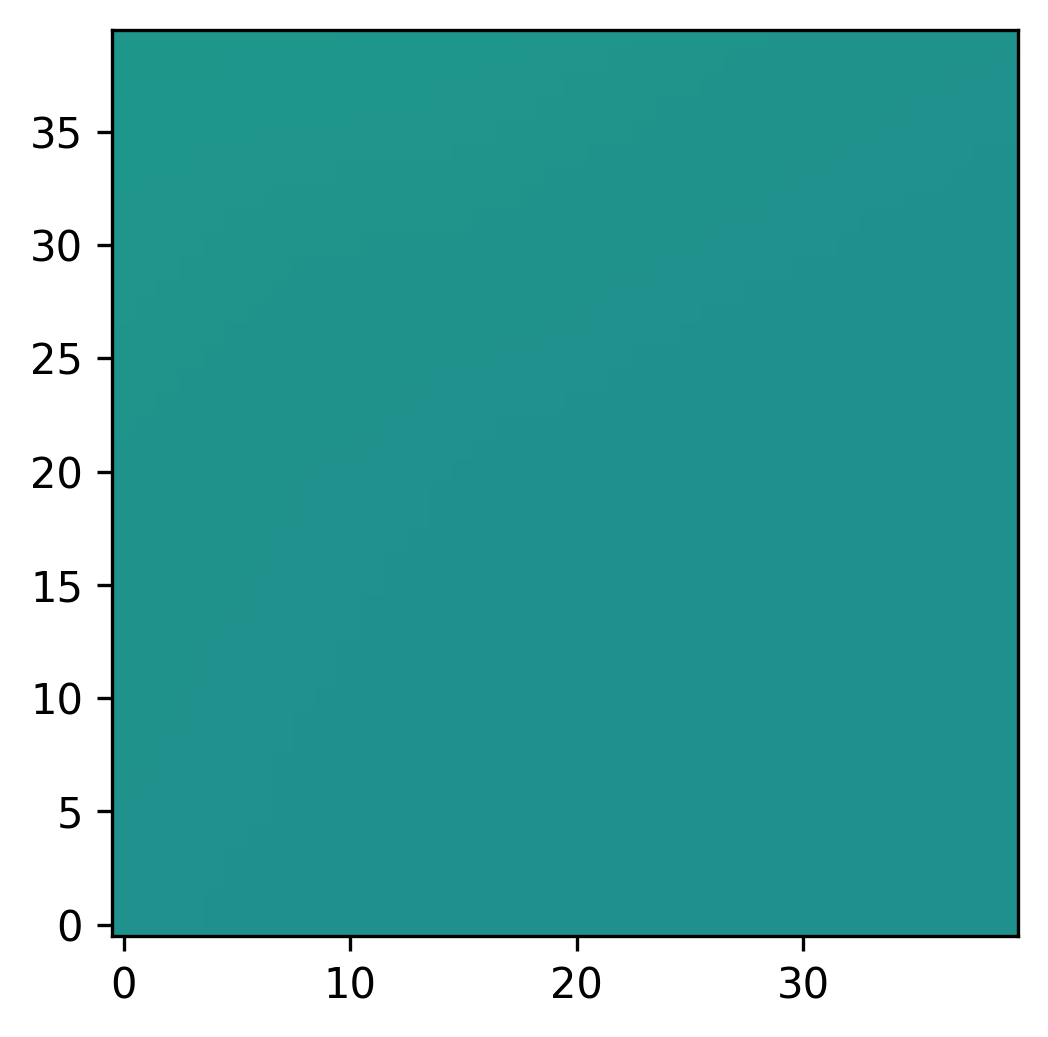

In [208]:
# try to evaluate the (randomly initialized) network
# on some area in the 2D plane
test_batchsize=np.shape(X0)[0]*np.shape(X0)[1]
testsample=np.zeros([test_batchsize,2])
testsample[:,0]=X0.flatten()
testsample[:,1]=X1.flatten()

testoutput=apply_net_simple(testsample,Weights,Biases)
myim=plt.imshow(np.reshape(testoutput,np.shape(X0)),
                origin='lower',interpolation='none',vmin=-.5,vmax=+.5)
plt.show()

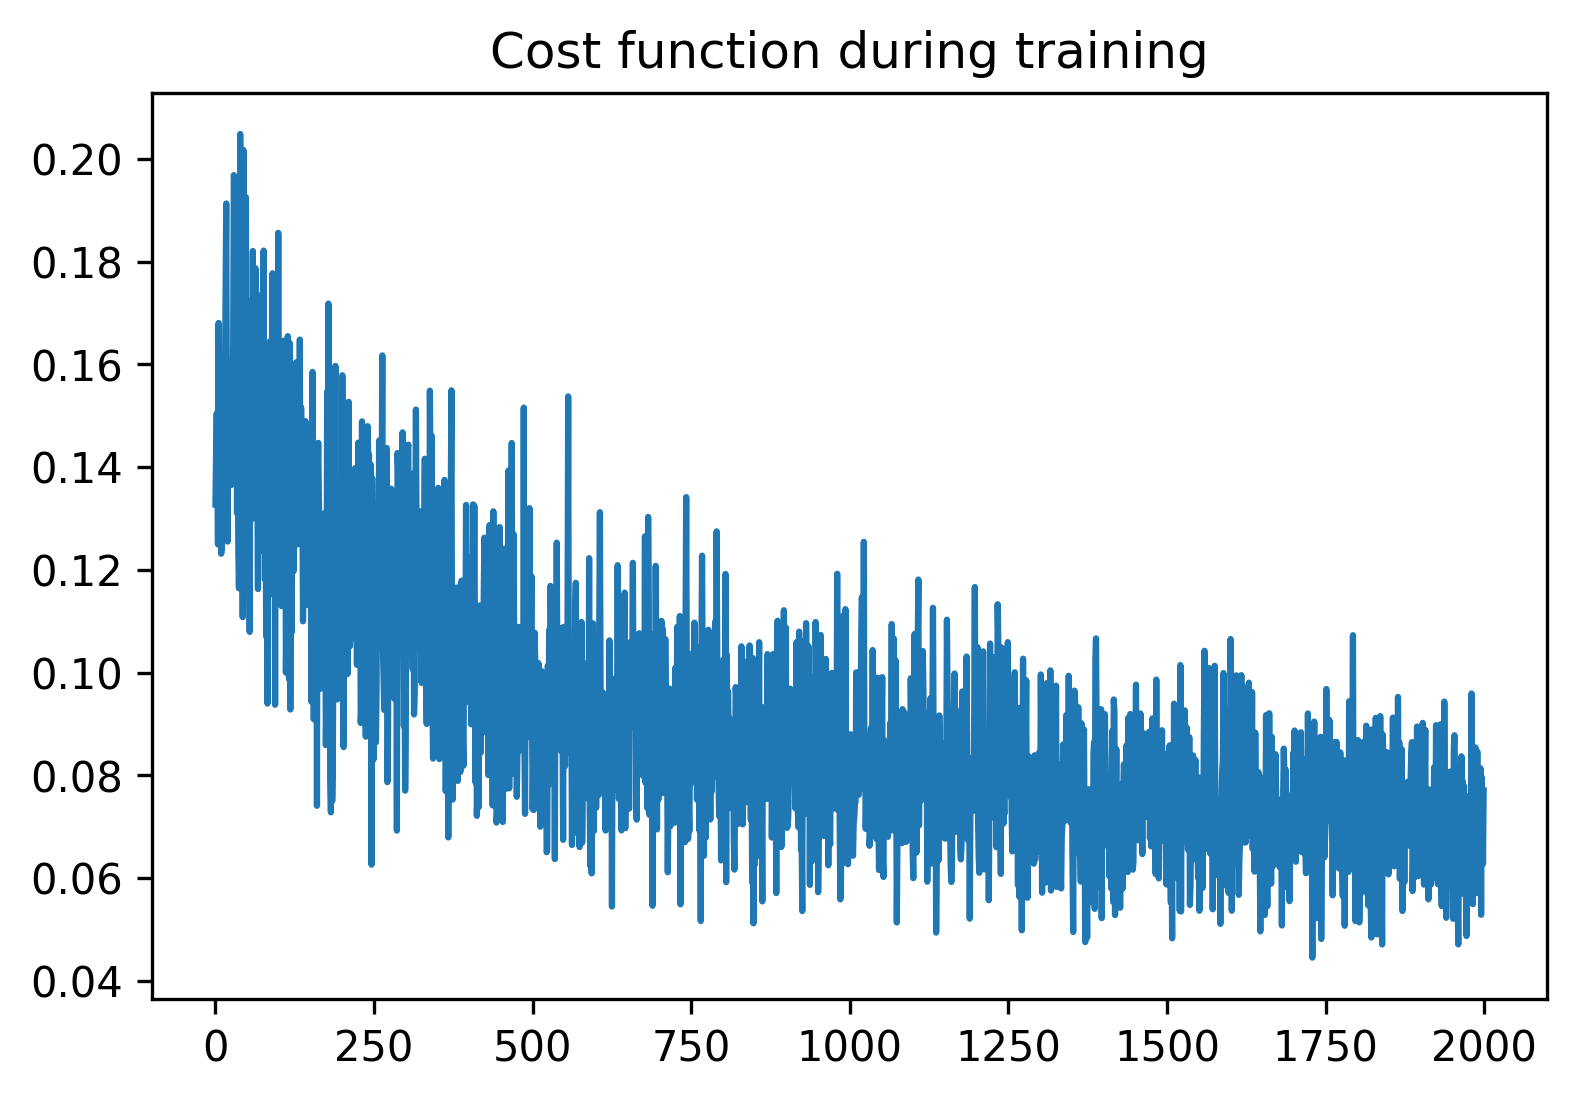

In [209]:
# now train on randomly sampled points
# to make the network reproduce better and
# better this 2D function!
eta=.001
batches=2000
costs=[]

for k in range(batches):
    x,y_target=make_batch(batchsize)
    y_out_result,cost,Weights,Biases=train_batch(x,y_target,eta, Weights,Biases)
    costs.append(cost)
    
plt.plot(costs)
plt.title("Cost function during training")
plt.show()


# Animate the network results during training

In [212]:
# start fresh:

# set up all the weights and biases

NumLayers=3 # does not count input-layer (but does count output)
LayerSizes=[2,50,20,1] # input-layer,hidden-1,hidden-2,...,output-layer

Weights=[0.1*np.random.randn( LayerSizes[j],LayerSizes[j+1] ) for j in range(NumLayers)]
Biases=[np.zeros(LayerSizes[j+1]) for j in range(NumLayers)]

batchsize=10

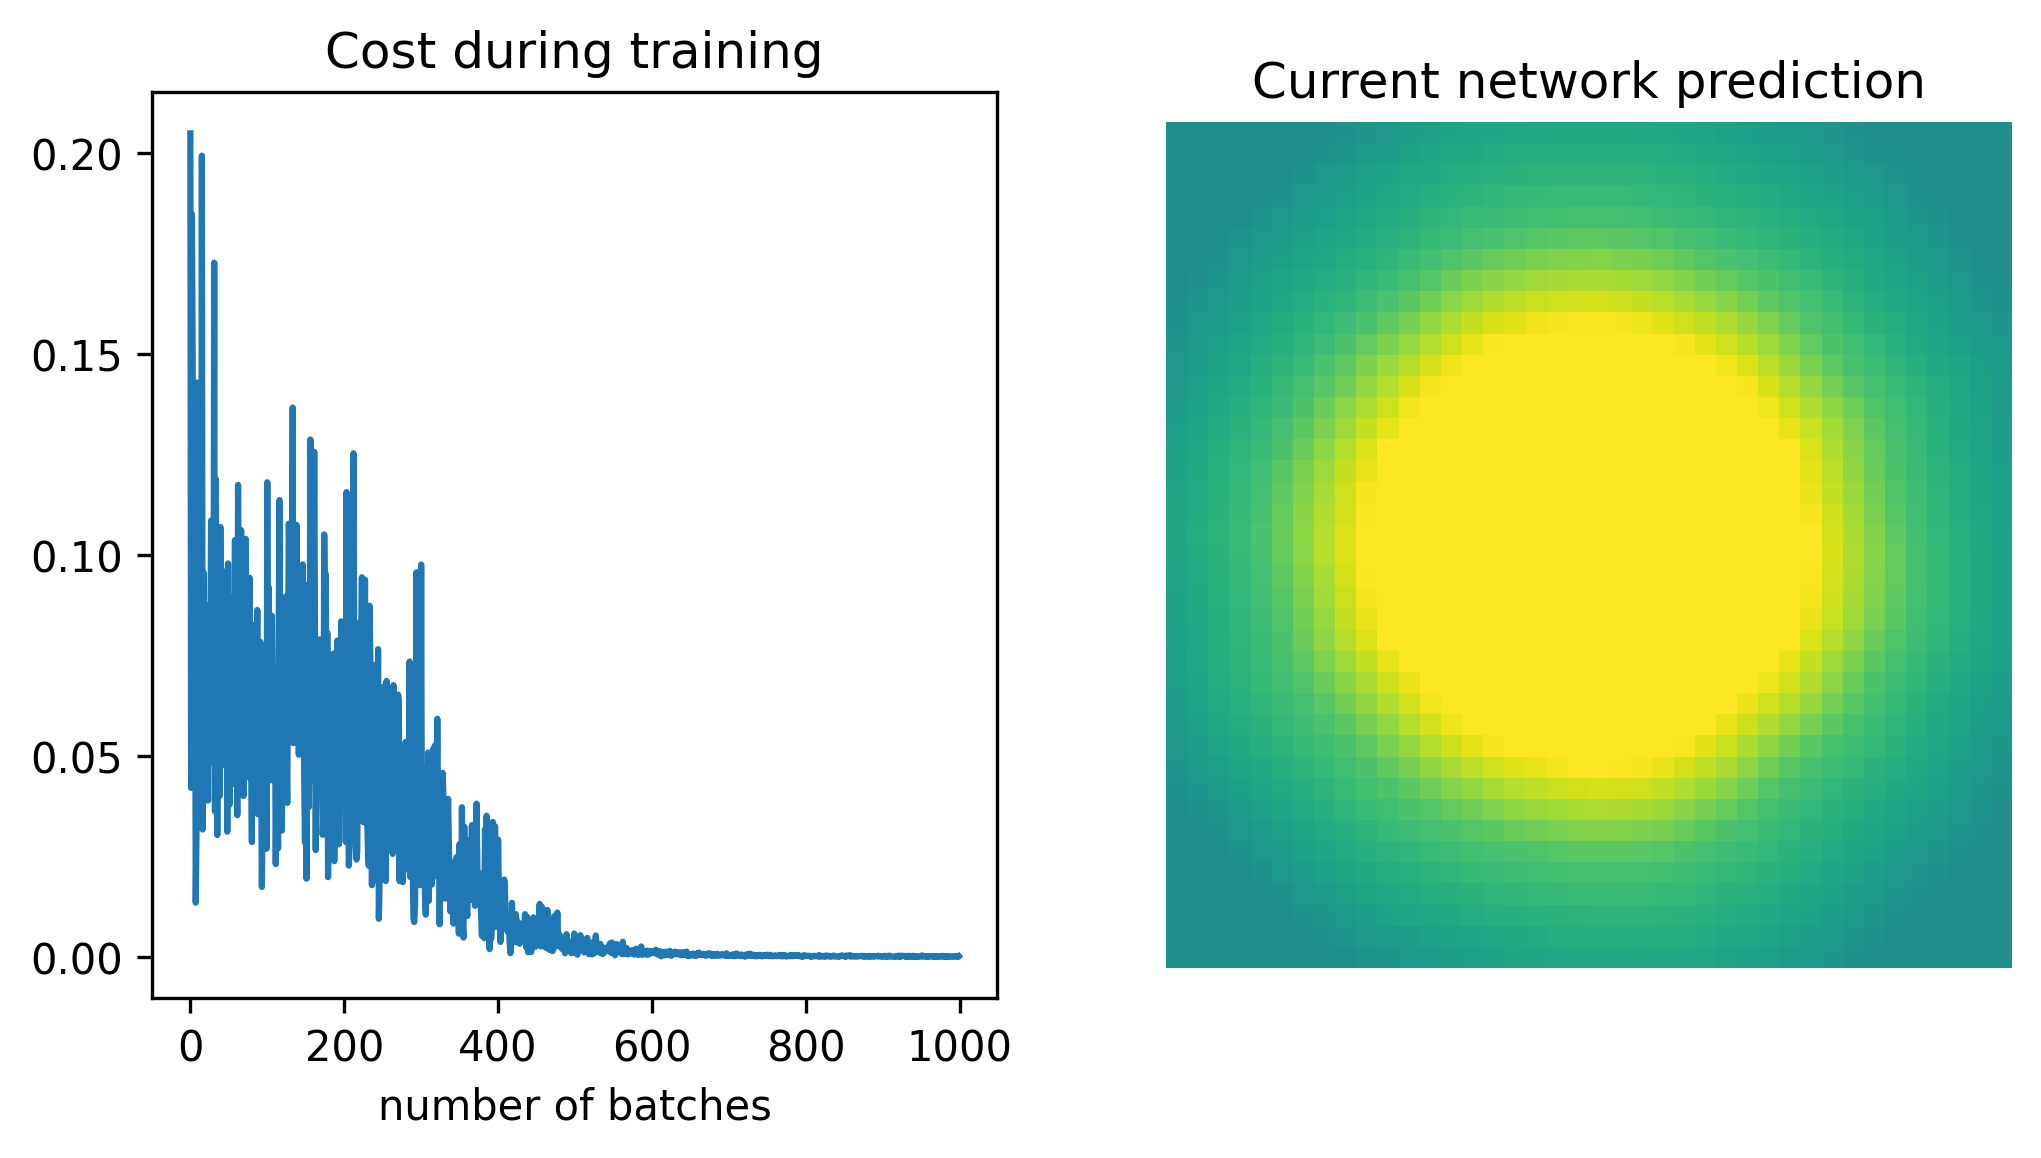

In [213]:
# import functions for updating display 
# (simple animation)
from IPython.display import clear_output
from time import sleep

eta=0.1 # learning rate
nsteps=1000

costs=[]
for j in range(nsteps):
    clear_output(wait=True)
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(8,4)) # prepare figure
    ax[1].axis('off') # no axes
    
    # the crucial lines:
    x,y_target=make_batch(batchsize) # random samples (points in 2D)
    # train network (one step, on this batch):
    y_out_result,cost,Weights,Biases=train_batch(x,y_target,eta, Weights,Biases) 
    costs.append(cost)
    # check the new network output:
    testoutput=apply_net_simple(testsample,Weights,Biases) 
    
    img=ax[1].imshow(np.reshape(testoutput,np.shape(X0)),
                     interpolation='nearest',origin='lower',
                     vmin=-.5,vmax=+.5) # plot image
    ax[0].plot(costs)
    
    ax[0].set_title("Cost during training")
    ax[0].set_xlabel("number of batches")
    ax[1].set_title("Current network prediction")
    plt.show()

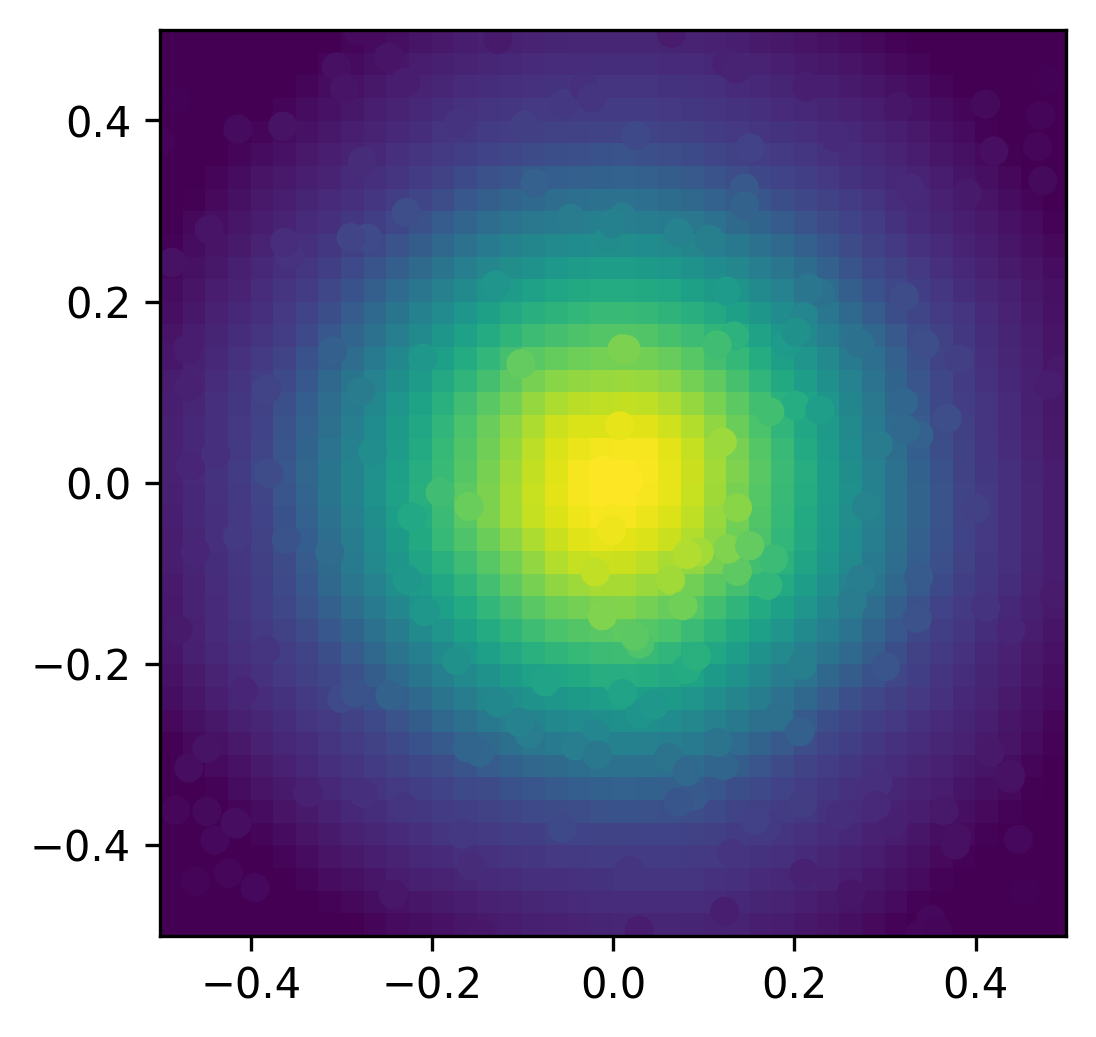

In [215]:
testoutput=apply_net_simple(testsample,Weights,Biases) 

x,y_target=make_batch(200)

plt.imshow(np.reshape(testoutput,np.shape(X0)),
                 interpolation='nearest',origin='lower',
          extent=(xrange[0],xrange[-1],xrange[0],xrange[-1]))
plt.scatter(x[:,0],x[:,1],c=y_target[:,0])
plt.show()